# Transfer Learning With Data Augumentation

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

## Load Data

In [2]:
# Data from: https://mmspg.epfl.ch/downloads/food-image-datasets/
# !wget --passive-ftp --prefer-family=ipv4 --ftp-user FoodImage@grebvm2.epfl.ch \
#  --ftp-password Cahc1moo -nc ftp://tremplin.epfl.ch/Food-5K.zip
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2020-12-24 13:33:03--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.81.48, 104.31.80.48
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  34.8MB/s    in 13s     

2020-12-24 13:33:16 (34.1 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
!unzip -qq -o Food-5K.zip

In [4]:
!ls Food-5K/training/

497.jpg  1_883.jpg
0_1266.jpg 0_302.jpg  0_69.jpg   1_1074.jpg 1_1460.jpg 1_498.jpg  1_884.jpg
0_1267.jpg 0_303.jpg  0_690.jpg  1_1075.jpg 1_1461.jpg 1_499.jpg  1_885.jpg
0_1268.jpg 0_304.jpg  0_691.jpg  1_1076.jpg 1_1462.jpg 1_5.jpg    1_886.jpg
0_1269.jpg 0_305.jpg  0_692.jpg  1_1077.jpg 1_1463.jpg 1_50.jpg   1_887.jpg
0_127.jpg  0_306.jpg  0_693.jpg  1_1078.jpg 1_1464.jpg 1_500.jpg  1_888.jpg
0_1270.jpg 0_307.jpg  0_694.jpg  1_1079.jpg 1_1465.jpg 1_501.jpg  1_889.jpg
0_1271.jpg 0_308.jpg  0_695.jpg  1_108.jpg  1_1466.jpg 1_502.jpg  1_89.jpg
0_1272.jpg 0_309.jpg  0_696.jpg  1_1080.jpg 1_1467.jpg 1_503.jpg  1_890.jpg
0_1273.jpg 0_31.jpg   0_697.jpg  1_1081.jpg 1_1468.jpg 1_504.jpg  1_891.jpg
0_1274.jpg 0_310.jpg  0_698.jpg  1_1082.jpg 1_1469.jpg 1_505.jpg  1_892.jpg
0_1275.jpg 0_311.jpg  0_699.jpg  1_1083.jpg 1_147.jpg  1_506.jpg  1_893.jpg
0_1276.jpg 0_312.jpg  0_7.jpg    1_1084.jpg 1_1470.jpg 1_507.jpg  1_894.jpg
0_1277.jpg 0_313.jpg  0_70.jpg   1_1085.jpg 1_1471.jpg 1_508.jpg  1_89

In [5]:
!mv Food-5K/* .

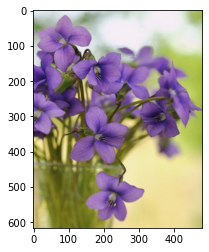

In [6]:
plt.imshow(image.load_img('training/0_603.jpg'))
plt.show()

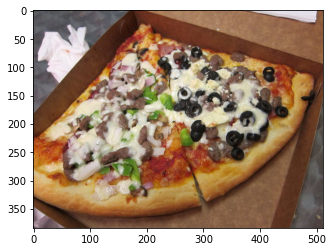

In [7]:
# Food images start with 1, non-food images start with 0
plt.imshow(image.load_img('training/1_603.jpg'))
plt.show()

In [8]:
!mkdir data

In [9]:
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [10]:
# Move the images
# Note: we will consider 'training' to be the train set
#       'validation' folder will be the test set
#       ignore the 'evaluation' set
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [11]:
train_path = 'data/train'
valid_path = 'data/test'

In [12]:
IMAGE_SIZE = [200, 200]

In [13]:
# useful for getting number of files
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [14]:
# useful for getting number of classes
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

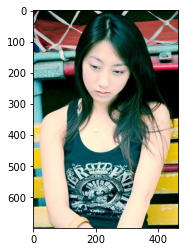

In [15]:
# Test random image
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

## Build Model

In [16]:
# define pretrained model
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58892288/58889256 [==============================] - 2s 0us/step


In [17]:
# freeze pretrained model weights
ptm.trainable = False

In [18]:
# Add dense layers
# map the data into feature vectors

# Keras image data generator returns classes one-hot encoded

K = len(folders) # number of classes
x = Flatten()(ptm.output) # flatten output of pretrained model
x = Dense(K, activation='softmax')(x)

In [19]:
model = Model(inputs=ptm.input, outputs=x)

In [20]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)      

In [21]:
# create image data generator instance
gen_train = ImageDataGenerator(
                            rotation_range=20,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            preprocessing_function=preprocess_input # apply vgg preprocessing 
                        )
gen_test = ImageDataGenerator(
                                preprocessing_function=preprocess_input # only apply preprocessing for test
                            )

In [22]:
batch_size = 128

#create generators

train_generator = gen_train.flow_from_directory(
                        train_path,
                        shuffle=True,
                        target_size=IMAGE_SIZE,
                        batch_size=batch_size)
valid_generator = gen_test.flow_from_directory(
                        valid_path,
                        target_size=IMAGE_SIZE,
                        batch_size=batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
model.compile(
  loss='categorical_crossentropy', # use categorical loss instead of spare when using with generator
  optimizer='adam',
  metrics=['accuracy']
)

## Training

In [24]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
  validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
24/24 [==============================] - 358s 15s/step - loss: 2.1968 - accuracy: 0.9053 - val_loss: 0.4502 - val_accuracy: 0.9810
Epoch 2/10
24/24 [==============================] - 330s 14s/step - loss: 0.4356 - accuracy: 0.9807 - val_loss: 0.3717 - val_accuracy: 0.9850
Epoch 3/10
24/24 [==============================] - 326s 14s/step - loss: 0.3958 - accuracy: 0.9813 - val_loss: 0.5116 - val_accuracy: 0.9810
Epoch 4/10
24/24 [==============================] - 333s 14s/step - loss: 0.2217 - accuracy: 0.9843 - val_loss: 0.4568 - val_accuracy: 0.9840
Epoch 5/10
24/24 [==============================] - 341s 14s/step - loss: 0.1175 - accuracy: 0.9903 - val_loss: 0.4058 - val_accuracy: 0.9820
Epoch 6/10
24/24 [==============================] - 332s 14s/step - loss: 0.1435 - accuracy: 0.9900 - val_loss: 0.4319 - val_accuracy: 0.9780
Epoch 7/10
24/24 [==============================] - 327s 14s/step - loss

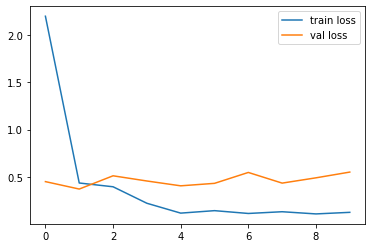

In [25]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

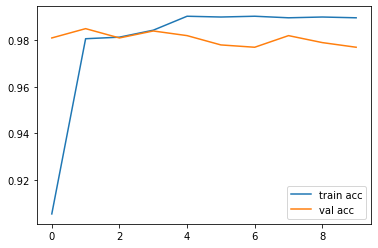

In [26]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

## Evaluate

Check true training accuracy without the data augumentation

In [27]:
# create a 2nd train generator which does not use data augmentation
# to get the true train accuracy
train_generator2 = gen_test.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
)
model.evaluate_generator(
    train_generator2,
    steps=int(np.ceil(len(image_files) / batch_size)))

Found 3000 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.02426433563232422, 0.9973333477973938]